Following this:
https://www.tensorflow.org/tutorials/keras/regression

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
import time

from tensorflow import keras
from keras import layers

from sklearn.metrics import mean_squared_error
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
df = pd.read_csv('./data/ouput.csv')

In [ ]:
df.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000168,2011-11-24 13:30:00,0.054
1,MAC000168,2011-11-24 14:00:00,0.178
2,MAC000168,2011-11-24 14:30:00,0.113
3,MAC000168,2011-11-24 15:00:00,0.068
4,MAC000168,2011-11-24 15:30:00,0.061


In [ ]:
#ser ut som linear regression ikke funker med datetime så må converte (https://stackoverflow.com/questions/40217369/python-linear-regression-predict-by-date)
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
df['tstp'] = df['tstp'].apply(lambda x: time.mktime(x.timetuple()))
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], errors="coerce")

In [ ]:
# id_training = 'MAC000150' 
# id_eval = 'MAC000152'


# def find_household(identification):
#     affluenthh_filt = df["LCLid"] == identification
#     affluent_hh_data = df[affluenthh_filt]
#     return affluent_hh_data

In [ ]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

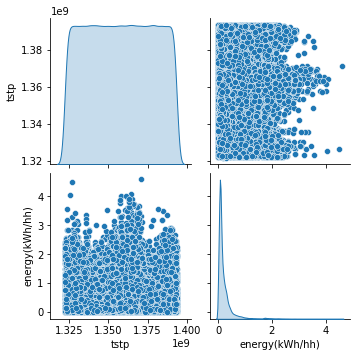

In [ ]:
#hmmmmmmmmmm
sns.pairplot(train_dataset[['LCLid','tstp', 'energy(kWh/hh)']], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tstp,317250.0,1.357841e+09,2.060140e+07,1.322039e+09,1.340005e+09,1.357855e+09,1.375686e+09,1.393542e+09
energy(kWh/hh),317242.0,2.172546e-01,3.021078e-01,0.000000e+00,6.800000e-02,1.180000e-01,2.500000e-01,4.595000e+00


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('energy(kWh/hh)')
test_labels = test_features.pop('energy(kWh/hh)')

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
tstp,1.357841e+09,2.060140e+07
energy(kWh/hh),2.172546e-01,3.021078e-01


In [ ]:
train_dataset.head()

,LCLid,tstp,energy(kWh/hh)
165447,MAC000165,1.334682e+09,0.315
276328,MAC000152,1.391467e+09,0.173
273500,MAC000152,1.386376e+09,0.036
389323,MAC000150,1.380508e+09,0.075
165070,MAC000165,1.334003e+09,0.268


dunno why normalization doesnt work, might be because of datetime (even tho i converted it to numeric?)

In [ ]:
#Normalize with keras
#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(np.array(train_features))

In [ ]:
#normalizer.mean.numpy()

In [ ]:
#linear regression
energy = np.array(train_features['tstp'])
energy_normalizor = layers.Normalization(input_shape=[1,], axis=None)
energy_normalizor.adapt(energy)

In [ ]:
#build the model
energy_model = tf.keras.Sequential([
    energy_normalizor,
    layers.Dense(units=1)
])

energy_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_15 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
energy_model.predict(energy[:10])

array([[ 0.915],
       [-1.328],
       [-1.127],
       [-0.896],
       [ 0.942],
       [ 1.124],
       [-0.824],
       [ 1.053],
       [-1.159],
       [-0.903]], dtype=float32)

In [ ]:
energy_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
loss='mean_absolute_error')

In [241]:
%%time
history = energy_model.fit(
    train_features['tstp'],
    train_labels,
    epochs=100,
    # Supress logging
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,NaN,NaN,95
96,NaN,NaN,96
97,NaN,NaN,97
98,NaN,NaN,98
99,NaN,NaN,99


In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [energy(kWh/hh)]')
    plt.legend()
    plt.grid(True)

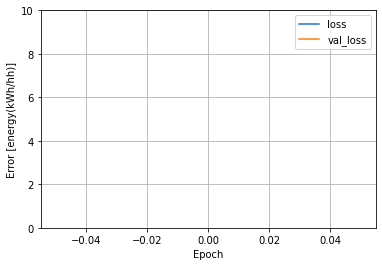

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['energy_model'] = energy_model.evaluate(
    test_features['tstp'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = energy_model.predict(x)

In [ ]:
def plot_energy(x, y):
  plt.scatter(train_features['tstp'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('tstp')
  plt.ylabel('energy(kWh/hh)')
  plt.legend()

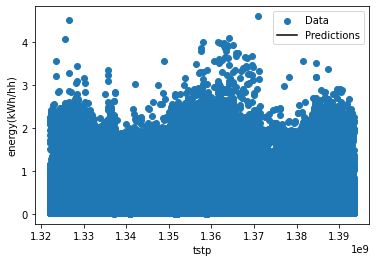

In [ ]:
plot_energy(x, y)